In [2]:
%cd ..


/Users/cory/Tetris_AI


In [4]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import csv
import time
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import f1_score
from pathlib import Path
import copy
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from app.tetris_dual import Game, ROWS, COLS, ORDER
from collections import deque
import os
import random
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt

## 💡 Reasoning for choosing a model

📝 Deep Q-Network (DQN) is a reinforcement learning algorithm that combines Q-learning with deep neural networks. It’s particularly effective for environments with large or continuous state spaces — like Tetris — where it’s impossible to enumerate all possible states. A DQN that uses a Convolutional Neural Network (CNN) is well-suited for Tetris because CNNs are excellent at extracting spatial features from grid-like data — such as the Tetris board. The game state can be represented as a 2D matrix (like an image), where each cell indicates whether it’s empty or filled.
CNNs automatically learn spatial patterns and local dependencies (for example, how blocks are stacked, where gaps appear, or where a line can be cleared). This makes them much more efficient than fully connected networks for understanding the structure of the board.

## 🧮 Mathematical view of CNN for Tetris

## 🧠 Mathematical formulation of Deep Q-Network (DQN) with one-step lookahead

### A. The agent learns an approximation of the optimal action-value function:

$
Q^*(s, a) = r(s, a) + \gamma \max_{a'} Q^*(s', a')
$

where  
- $ s $ — current state (board configuration + current piece),  
- $ a $ — action (rotation + column),  
- $ r(s,a) $ — immediate reward,  
- $ s' $ — next state,  
- $ \gamma \in [0,1) $ — discount factor.

---

### B. The DQN model is optimized to minimize the **Bellman loss**:

$
L(\theta) = \mathbb{E}\Big[(Q_\theta(s,a) - (r + \gamma (1 - done)\max_{a'} Q_{\theta^-}(s',a')))^2\Big]
$

where $ Q_{\theta^-} $ is a *target network* with frozen parameters for stability.

The gradient update step:

$
\theta \leftarrow \theta - \alpha \nabla_\theta L(\theta)
$

---

### C. One-step lookahead strategy

Instead of choosing the action purely by $ \arg\max_a Q_\theta(s,a) $,
the agent simulates all possible next states $ s'_a $ and computes:

$
Q_{\text{total}}(a) = r_a + \gamma (1 - done_a)\max_{a'} Q_\theta(s'_a, a')
$

The final action is selected as:

$
a_t = \arg\max_a Q_{\text{total}}(a)
$

This allows the agent to consider **the real, deterministic consequences** of each move,
making decision-making more stable and effective in Tetris.


## ⚡⚡⚡🛤️ Сhallenges along the way 

📝 Training the model turned out to be the most challenging part, as I initialDly was heading in the wrong direction. In an attempt to improve performance, I kept making the model more complex, moving to double DQN and dueling DQN, but this did not yield the expected results and significantly increased training time—up to several days. Eventually, I decided to return to a standard DQN and incorporated the **lookahead idea**, which already showed noticeable improvement in the first few hundred episodes.

## 🎮 Tetris environment 

📝 Developing a training environment for Tetris presented a significant challenge. One of the most difficult aspects was designing and tuning the reward system. When the reward structure was too simple, the agent quickly reached a local optimum and failed to learn more complex gameplay patterns. Conversely, an overly complex or poorly balanced reward system produced the opposite effect: the agent became reluctant to explore and, in some cases, concluded that the optimal strategy was to lose as quickly as possible. This behavior typically emerged when the agent received substantial penalties for factors such as holes, excessive height, or surface unevenness

In [14]:
class TetrisEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 60}

    def __init__(self):
        super().__init__()
        self.game = Game()
        self.action_space = spaces.Discrete(4 * COLS)
        self.observation_space = spaces.Dict({
            'board': spaces.Box(low=0.0, high=1.0, shape=(1, ROWS, COLS), dtype=np.float32),
            'kind': spaces.Discrete(len(ORDER))
        })
        self.height_penalty_factor = 0.02
        self.hole_penalty_factor = 0.01

    def calculate_max_height(self, game_obj):
        grid = game_obj.board.create_grid()
        max_height = 0
        for c in range(COLS):
            col_height = 0
            for r in range(ROWS):
                if grid[r][c] is not None:
                    col_height = ROWS - r
                    break
            max_height = max(max_height, col_height)
        return max_height

    def calculate_holes(self, game_obj):
        grid = game_obj.board.create_grid()
        holes = 0
        for c in range(COLS):
            block_above = False
            for r in range(ROWS):
                if grid[r][c] is not None:
                    block_above = True
                elif block_above:
                    holes += 1
        return holes

    def reset(self, *, seed=None, options=None):
        self.game = self.game.__class__()
        return self.get_state(), {}

    def get_state_from_game(self, game_obj):
        grid = game_obj.board.create_grid()
        binary_grid = np.zeros(shape=(ROWS, COLS), dtype=np.float32)
        for r in range(ROWS):
            for c in range(COLS):
                if grid[r][c] is not None:
                    binary_grid[r][c] = 1.0
        board_state = np.expand_dims(binary_grid, axis=0)

        try:
            current_kind_str = game_obj.current.kind
            kind_idx = ORDER.index(current_kind_str)
        except (AttributeError, ValueError, IndexError):
            kind_idx = 0
        return {'board': board_state, 'kind': kind_idx}

    def get_state(self):
        return self.get_state_from_game(self.game)

    def calculate_reward(self, game_obj, lines_cleared, done):
        reward = 1.0
        if lines_cleared == 1:
            reward += 40
        elif lines_cleared == 2:
            reward += 100
        elif lines_cleared == 3:
            reward += 300
        elif lines_cleared == 4:
            reward += 1200

        max_height = self.calculate_max_height(game_obj)
        height_penalty = self.height_penalty_factor * (max_height ** 2)
        reward -= height_penalty

        num_holes = self.calculate_holes(game_obj)
        hole_penalty = self.hole_penalty_factor * num_holes
        reward -= hole_penalty
        if done:
            reward -= 5.0

        return reward

    def render(self):
        pass

    def step(self, action):
        rot, col = divmod(action, COLS)
        piece = self.game.current.rotated(rot)
        piece.x = col
        lines_before = self.game.lines
        valid_move = self.game.board.valid(piece)
        if valid_move:
            self.game.current = piece
        self.game.hard_drop()
        lines_cleared = self.game.lines - lines_before
        done = self.game.over
        reward = self.calculate_reward(self.game, lines_cleared, done)
        return self.get_state(), reward, done, False, {}

    def get_next_states(self):
        next_states_info = {}
        try:
            current_kind_idx = ORDER.index(self.game.current.kind)
        except (AttributeError, ValueError, IndexError):
            current_kind_idx = 0
        for action in range(self.action_space.n):
            sim_game = copy.deepcopy(self.game)

            rot, col = divmod(action, COLS)
            piece = sim_game.current.rotated(rot)
            piece.x = col
            lines_before = sim_game.lines

            valid_move = sim_game.board.valid(piece)
            if valid_move:
                sim_game.current = piece
            sim_game.hard_drop()
            lines_cleared = sim_game.lines - lines_before
            done = sim_game.over
            reward = self.calculate_reward(sim_game, lines_cleared, done)
            next_state_dict = self.get_state_from_game(sim_game)
            next_states_info[action] = (next_state_dict, reward, done)

        return next_states_info, current_kind_idx

## 🤖 Model

📝 This section presents one of the most successful architectures, which, however, is not optimal. The agent training process was carried out across multiple environments, but only one of them is presented here — the one that demonstrated the most stable results. Nevertheless, this environment also has potential for further improvement.

In [17]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DeepQNetwork(nn.Module):
    def __init__(self, h=ROWS, w=COLS, num_kinds=len(ORDER), num_actions=4 * COLS):
        super().__init__()
        input_channels = 1
        self.num_actions = num_actions
        self.num_kinds = num_kinds
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Flatten()
        )
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, h, w)
            conv_out_size = self.conv(dummy_input).shape[1]
        self.fc_shared = nn.Sequential(
            nn.Linear(conv_out_size + num_kinds, 256), nn.ReLU()
        )
        self.fc_output = nn.Linear(256, num_actions)

    def forward(self, state_input):
        board_tensor = state_input['board']
        kind_tensor = state_input['kind']

        if board_tensor.dim() == 3:
            board_tensor = board_tensor.unsqueeze(1)
        if board_tensor.shape[1] != 1:
            board_tensor = board_tensor.reshape(-1, 1, ROWS, COLS)
        conv_features = self.conv(board_tensor)
        kind_onehot = F.one_hot(kind_tensor.long(), num_classes=self.num_kinds).float()
        if kind_onehot.dim() == 1:
            kind_onehot = kind_onehot.unsqueeze(0)
        combined_features = torch.cat([conv_features, kind_onehot], dim=1)
        shared_output = self.fc_shared(combined_features)
        q = self.fc_output(shared_output)
        return q

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, s_dict, a, r, next_s_dict, d):
        self.memory.append((s_dict, a, r, next_s_dict, d))

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        boards = np.concatenate([s['board'] for s in states], axis=0)
        kinds = np.array([s['kind'] for s in states], dtype=np.int64)
        next_boards = np.concatenate([s['board'] for s in next_states], axis=0)
        next_kinds = np.array([s['kind'] for s in next_states], dtype=np.int64)
        actions = np.array(actions, dtype=np.int64)
        rewards = np.array(rewards, dtype=np.float32)
        dones = np.array(dones, dtype=np.float32)
        batch_dict = (
            {'board': boards, 'kind': kinds},
            actions,
            rewards,
            {'board': next_boards, 'kind': next_kinds},
            dones
        )
        return batch_dict

    def __len__(self):
        return len(self.memory)


GAMMA = 0.99
LR = 1e-4
BATCH_SIZE = 64
MEMORY_SIZE = 30000
TARGET_UPDATE = 500
EPS_START = 1
EPS_END = 0.05
EPISODES = 1000
EPS_DECAY_FRAMES = 10000.0

CHECKPOINT_FILE = "checkpoint.pth"
BEST_MODEL_FILE = "best.pth"

def epsilon_by_frame(current_frame_idx):
    return max(EPS_END, EPS_START - current_frame_idx * (EPS_START - EPS_END) / EPS_DECAY_FRAMES)


def optimize_model(mem, p_net, t_net, agent_optimizer):
    if len(mem) < BATCH_SIZE:
        return None

    (states_dict, actions, rewards, next_states_dict, dones) = mem.sample(BATCH_SIZE)
    states_board_v = torch.from_numpy(states_dict['board']).float().to(DEVICE)
    states_kind_v = torch.from_numpy(states_dict['kind']).long().to(DEVICE)
    next_states_board_v = torch.from_numpy(next_states_dict['board']).float().to(DEVICE)
    next_states_kind_v = torch.from_numpy(next_states_dict['kind']).long().to(DEVICE)
    actions_v = torch.from_numpy(actions).long().to(DEVICE).unsqueeze(1)
    rewards_v = torch.from_numpy(rewards).float().to(DEVICE)
    dones_v = torch.from_numpy(dones).float().to(DEVICE)

    current_state_input = {'board': states_board_v, 'kind': states_kind_v}
    next_state_input = {'board': next_states_board_v, 'kind': next_states_kind_v}
    q_values = p_net(current_state_input).gather(1, actions_v).squeeze(1)

    with torch.no_grad():
        next_q_values_max = t_net(next_state_input).max(dim=1)[0]
        next_q_values_max = next_q_values_max * (1.0 - dones_v)
        target_q_values = rewards_v + (GAMMA * next_q_values_max)
    loss_fn = nn.MSELoss()
    loss = loss_fn(q_values, target_q_values)
    agent_optimizer.zero_grad()
    loss.backward()
    agent_optimizer.step()

    return loss.item()

if __name__ == '__main__':

    print("Starting CNN training...:", DEVICE)
    env = TetrisEnv()
    action_dim = env.action_space.n
    print(f"Action dimensions: {action_dim}")

    policy_net = DeepQNetwork(h=ROWS, w=COLS, num_kinds=len(ORDER), num_actions=action_dim).to(DEVICE)
    target_net = DeepQNetwork(h=ROWS, w=COLS, num_kinds=len(ORDER), num_actions=action_dim).to(DEVICE)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=LR)
    memory = ReplayMemory(MEMORY_SIZE)
    start_ep = 1
    frame_idx = 0
    best_reward = -float('inf')

    all_rewards = []
    all_steps = []
    all_losses = []

    if os.path.exists(CHECKPOINT_FILE):
        print(f"Checking {CHECKPOINT_FILE}...")
        try:
            checkpoint = torch.load(CHECKPOINT_FILE, map_location=DEVICE, weights_only=False)
            policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
            target_net.load_state_dict(checkpoint['target_net_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            memory = checkpoint['memory']
            start_ep = checkpoint['epoch'] + 1
            frame_idx = checkpoint['frame_idx']
            best_reward = checkpoint.get('best_reward', -float('inf'))
            
            all_rewards = checkpoint.get('all_rewards', [])
            all_steps = checkpoint.get('all_steps', [])
            all_losses = checkpoint.get('all_losses', [])
            
            print(f"*** Resuming RL training from episode {start_ep} (frame {frame_idx}) ***")
        except (FileNotFoundError, KeyError, RuntimeError, EOFError) as e:
            print(f"Error loading RL checkpoint, starting fresh: {e}.")
            memory = ReplayMemory(MEMORY_SIZE)
            all_rewards = []
            all_steps = []
            all_losses = []


    for ep in range(start_ep, EPISODES + 1):
        state_dict, _ = env.reset()
        total_reward = 0.0
        steps = 0
        done = False
        
        ep_losses = []

        while not done:
            eps = epsilon_by_frame(frame_idx)
            action = 0
            if random.random() < eps:
                action = env.action_space.sample()
            else:
                next_states_info, current_kind_idx = env.get_next_states()

                all_next_boards = np.concatenate([info[0]['board'] for info in next_states_info.values()], axis=0)
                all_next_kinds = np.array([info[0]['kind'] for info in next_states_info.values()], dtype=np.int64)

                all_rewards_list = np.array([info[1] for info in next_states_info.values()], dtype=np.float32)
                all_dones = np.array([info[2] for info in next_states_info.values()], dtype=np.float32)

                lookahead_boards_v = torch.from_numpy(all_next_boards).float().to(DEVICE)
                lookahead_kinds_v = torch.from_numpy(all_next_kinds).long().to(DEVICE)
                lookahead_rewards_v = torch.from_numpy(all_rewards_list).float().to(DEVICE)
                lookahead_dones_v = torch.from_numpy(all_dones).float().to(DEVICE)

                lookahead_state_input = {'board': lookahead_boards_v, 'kind': lookahead_kinds_v}
                with torch.no_grad():
                    lookahead_next_q_max = policy_net(lookahead_state_input).max(dim=1)[0]
                    lookahead_next_q_max = lookahead_next_q_max * (1.0 - lookahead_dones_v)
                    total_q_values = lookahead_rewards_v + (GAMMA * lookahead_next_q_max)

                action = int(torch.argmax(total_q_values).item())

            next_state_dict, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            memory.push(state_dict, action, reward, next_state_dict, float(done))

            state_dict = next_state_dict
            total_reward += reward
            steps += 1
            frame_idx += 1
            current_loss = optimize_model(memory, policy_net, target_net, optimizer)

            if current_loss is not None:
                ep_losses.append(current_loss)

        if ep % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

        avg_loss = np.mean(ep_losses) if ep_losses else None
        all_rewards.append(total_reward)
        all_steps.append(steps)
        all_losses.append(avg_loss)

        loss_str = f"{avg_loss:.4f}" if avg_loss is not None else "N/A"

        if total_reward > best_reward:
            best_reward = total_reward
            torch.save(policy_net.state_dict(), BEST_MODEL_FILE)
            print(f"*** New best reward: {best_reward:.2f}, best model saved. ***")

        if ep % 500 == 0:
            print("--- Saving RL checkpoint... ---")
            torch.save({
                'epoch': ep, 'frame_idx': frame_idx,
                'policy_net_state_dict': policy_net.state_dict(),
                'target_net_state_dict': target_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'memory': memory, 'best_reward': best_reward,
                'all_rewards': all_rewards,
                'all_steps': all_steps,
                'all_losses': all_losses,
            }, CHECKPOINT_FILE)

    torch.save(policy_net.state_dict(), "dqn_tetris_final_lookahead_dqn.pth")

    print("Saving numerical results...")
    np.save("tetris_rewards.npy", np.array(all_rewards))
    np.save("tetris_steps.npy", np.array(all_steps))
    np.save("tetris_losses.npy", np.array([l for l in all_losses if l is not None]))
    print("Numerical results saved.")

Starting CNN training...: cpu
Action dimensions: 40
*** New best reward: -66.25, best model saved. ***
*** New best reward: -50.50, best model saved. ***
*** New best reward: -36.69, best model saved. ***
*** New best reward: -20.64, best model saved. ***
*** New best reward: -13.81, best model saved. ***
*** New best reward: -1.74, best model saved. ***
*** New best reward: 3.50, best model saved. ***
*** New best reward: 81.42, best model saved. ***
*** New best reward: 151.75, best model saved. ***
*** New best reward: 233.52, best model saved. ***
*** New best reward: 253.41, best model saved. ***
*** New best reward: 329.24, best model saved. ***
*** New best reward: 366.78, best model saved. ***
*** New best reward: 406.97, best model saved. ***
*** New best reward: 407.07, best model saved. ***
*** New best reward: 516.31, best model saved. ***
*** New best reward: 612.61, best model saved. ***
*** New best reward: 707.21, best model saved. ***
*** New best reward: 769.25, best 

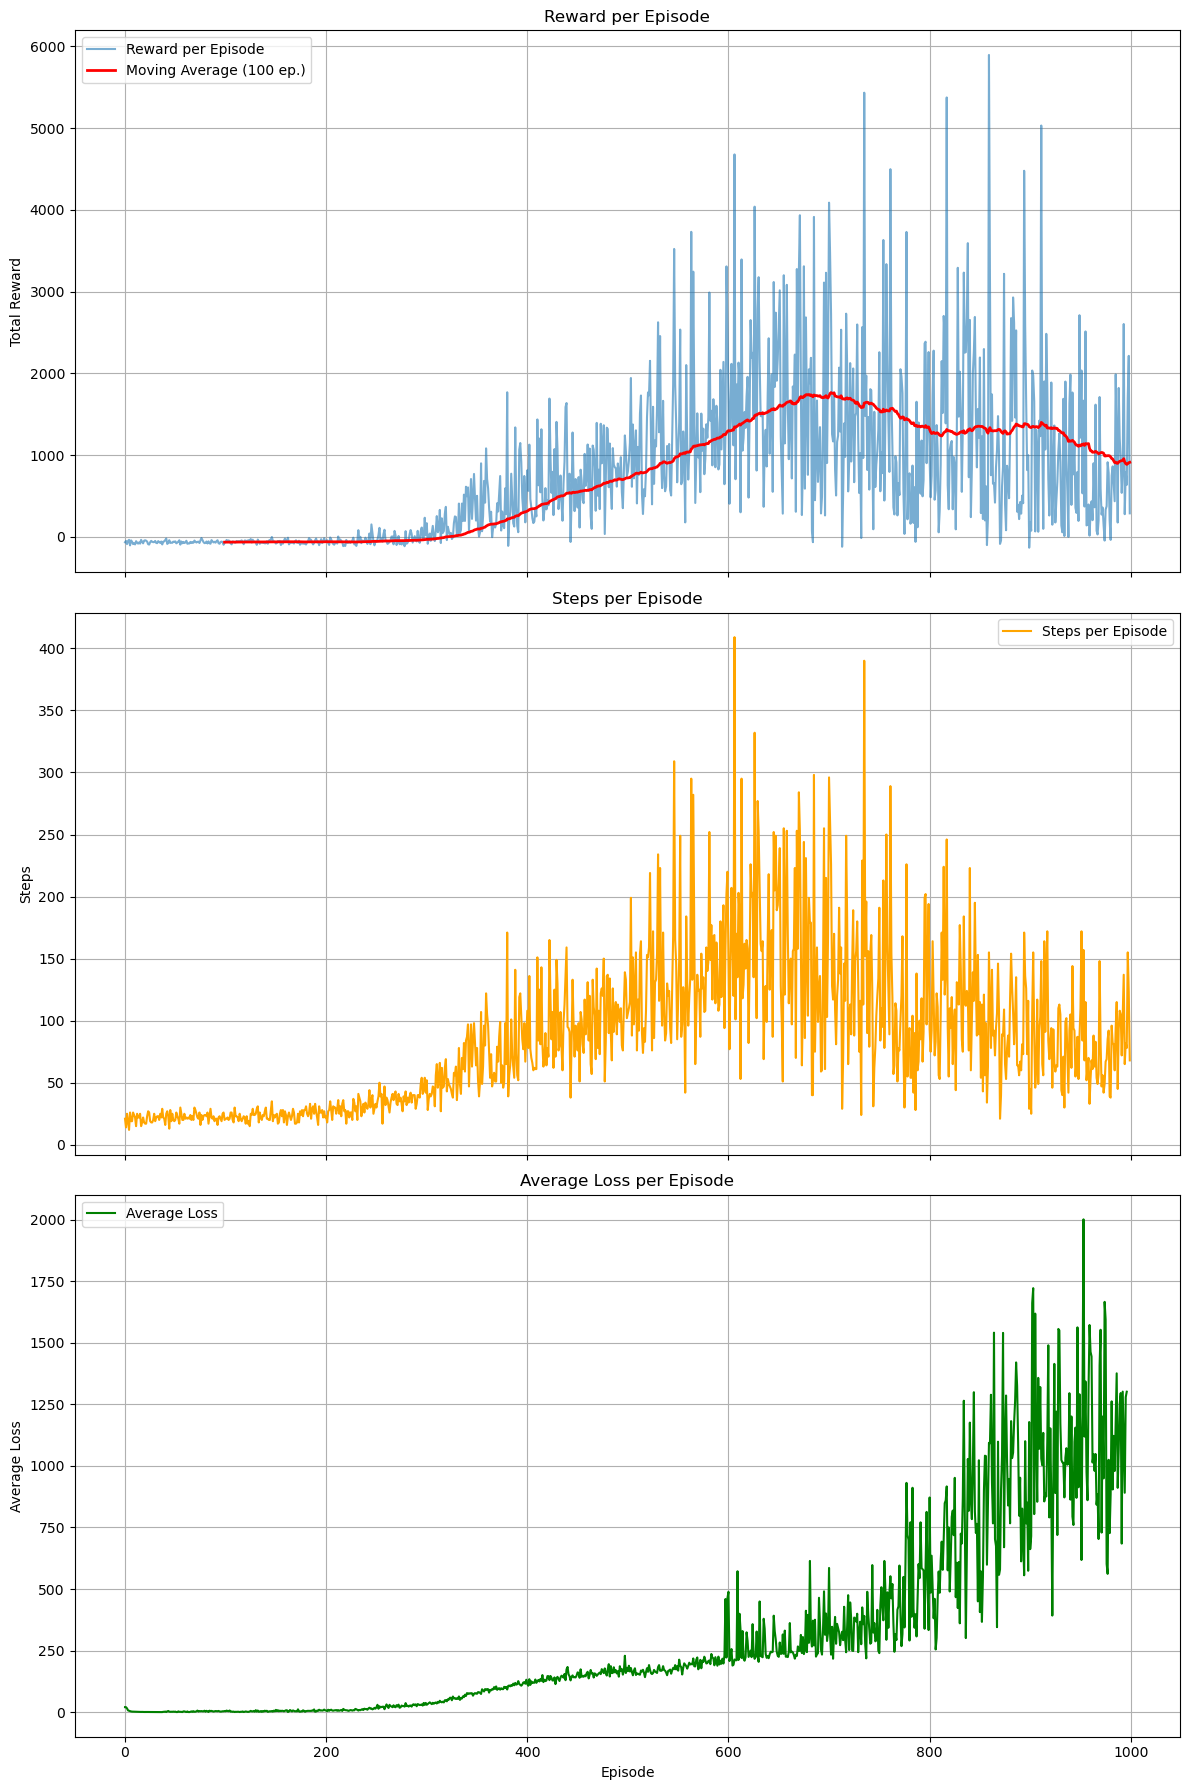

In [20]:
def plot_results(rewards, steps, losses):
    import matplotlib.pyplot as plt
    import numpy as np
ы
    moving_avg_window = 100
    rewards_ma = []
    if len(rewards) >= moving_avg_window:
        rewards_ma = np.convolve(rewards, np.ones(moving_avg_window)/moving_avg_window, mode='valid')
    
    fig, ax = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

    # reward
    ax[0].plot(rewards, label='Reward per Episode', alpha=0.6)
    if len(rewards_ma) > 0:
        ax[0].plot(np.arange(moving_avg_window - 1, len(rewards)), rewards_ma, 
                   label=f'Moving Average ({moving_avg_window} ep.)', color='red', linewidth=2)
    ax[0].set_ylabel('Total Reward')
    ax[0].set_title('Reward per Episode')
    ax[0].legend()
    ax[0].grid(True)

    # steps
    ax[1].plot(steps, label='Steps per Episode', color='orange')
    ax[1].set_ylabel('Steps')
    ax[1].set_title('Steps per Episode')
    ax[1].legend()
    ax[1].grid(True)

    # loss
    valid_losses = [l for l in losses if l is not None]
    if valid_losses:
        ax[2].plot(valid_losses, label='Average Loss', color='green')
        ax[2].set_ylabel('Average Loss')
        ax[2].set_title('Average Loss per Episode')
        ax[2].legend()
        ax[2].grid(True)

    ax[2].set_xlabel('Episode')
    
    plt.tight_layout()
    plt.show()
plot_results(all_rewards, all_steps, all_losses)

📝 The graphs show that the DQN agent gradually learned to play better:
Reward and Steps per Episode increase during the first half of training — the agent survives longer and achieves higher scores.
After around episode 500, there is stabilization and fluctuations, indicating the agent has reached the limit of its current strategy.
Loss increases over time, suggesting instability in training, possible overfitting, or growing Q-value error.
Overall, the model demonstrates successful learning but requires additional stabilization (e.g., a lower learning rate and more frequent target network updates).